<a href="https://colab.research.google.com/github/AntoineGilsonGH/Probability-of-flipped-results/blob/main/Probabilities_of_flipping_Dice_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probability of flipping - DICE (DSC)

We compute:
$$P(\mu_A \leq \mu_B | x)$$

where
- $\mu_A$ is the average Dice of the best-ranked method
- $\mu_B$ is the average Dice of the second best-ranked method

The probability is computed by sampling from the posterior :    
$$
p(\mu_A - \mu_B | x) = p(\mu | x) = \mathcal{N} \left( \mu ; \bar{x}, \frac{\sigma^2}{n} \right) \quad \text{with} \quad \sigma^2 = \sigma_A^2 + \sigma_B^2 - 2\sigma_A\sigma_B \rho_{AB}
$$

It leads to :

$$
= p(\mu < 0 \mid \mathbf{x}) \\
=  \int_{-\infty}^{0} \mathcal{N} \left( \mu; \bar{x}, \frac{\sigma^2}{n} \right) d\mu \\
= P \left( \bar{x} + \frac{\sigma}{\sqrt{n}} Z < 0 \right) \quad \text{with} \quad Z \sim \mathcal{N}(0,1) \\
= P \left( Z < \sqrt{n} \frac{m_B - m_A}{\sqrt{\sigma_A^2 + \sigma_B^2 - 2\sigma_A \sigma_B \rho_{AB}}} \right)
$$

where $m_A$ and $m_B$ and the empirical means of the DICE score of A and B.

On the other hand, we have to input the value of $σ_A$ and $σ_B$ because we do not necessarily have them in the articles.

$$
\text{Log}(σ) = 2.0310 + 0.0726 \cdot DSC_{\mu} - 0.0008 \cdot DSC_{\mu}^2
$$


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [ ]:
def sd_imputation(dice):
  dice_100 = 100*dice
  log_sd = 2.0310 + 0.0726*dice_100 - 0.0008*(dice_100)**2
  return np.exp(log_sd)/100

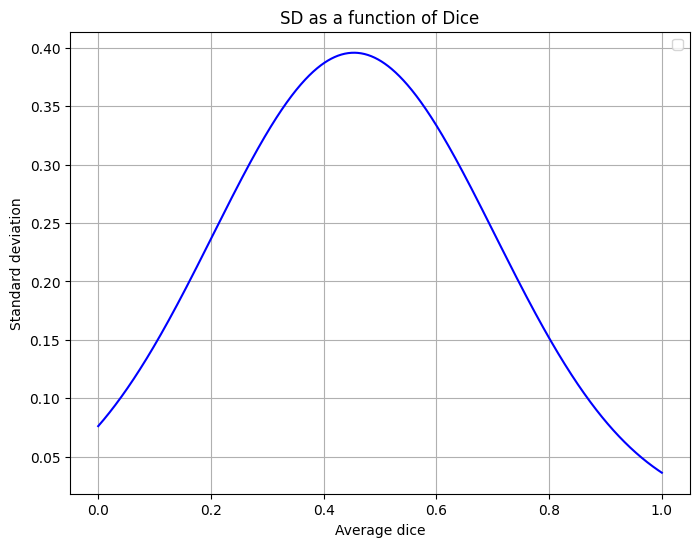

In [ ]:
DICE_example_values = np.linspace(0, 1, 1000)

SD_values = sd_imputation(DICE_example_values)

plt.figure(figsize=(8, 6))
plt.plot(DICE_example_values, SD_values, label="", color='blue')
plt.title('SD as a function of Dice')
plt.xlabel('Average dice')
plt.ylabel('Standard deviation')
plt.grid(True)
plt.legend()
plt.show()

# Let's compute the probability of flipping

In [ ]:
def proba_of_flipping_dice(n,mA,mB,rhoAB):

    """
    Args:
    n (int): Sample size.
    m_A (float): Average DICE of method A
    m_B (float): Average DICE of method B
    rho_AB (float): Correlation between A and B.

    Returns:
    float: Probability of flipping.
    """

    sd_A = sd_imputation(mA)
    sd_B = sd_imputation(mB)

    Z_stat = np.sqrt(n)*(mB-mA)/(np.sqrt(sd_A**2 + sd_B**2 - 2 * sd_A * sd_B * rhoAB))

    proba_flip = norm.cdf(Z_stat)

    return proba_flip


In [ ]:
proba_of_flipping_dice(100, 0.8,0.79,0.5)

0.26086082397455956

# Display how the probability of flipping varies as a function of ($m_A-m_B$) (and for varying $m_A$)

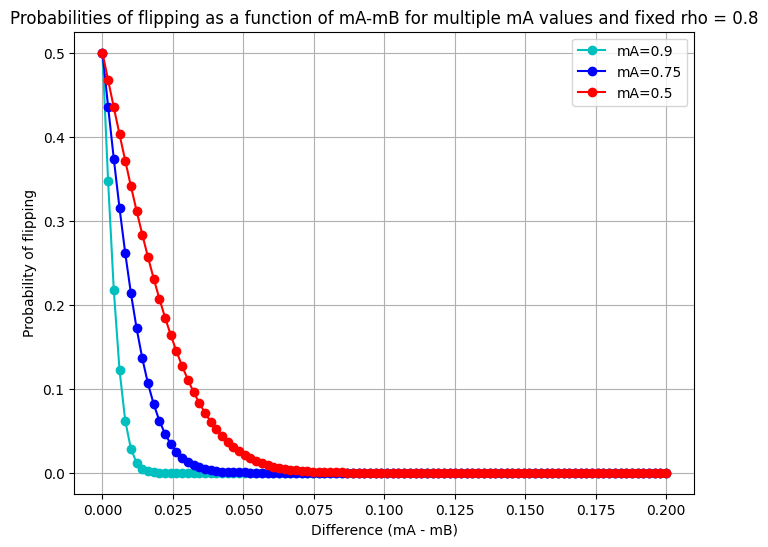

In [ ]:
def varying_diff_proba_flip(n, maxdiff, rhoAB):


   diff=[]
   for d in np.linspace(maxdiff,0, 100):
       diff.append(d)

   mA=0.9
   counts09 = []
   for mB in np.linspace(mA-maxdiff, mA, 100):
     try:
       counts09.append(proba_of_flipping_dice(n,mA,mB,rhoAB))
     except ValueError as e:
       counts09.append(None)


   mA = 0.75
   counts075 = []

   for mB in np.linspace(mA-maxdiff, mA, 100):
     try:
       counts075.append(proba_of_flipping_dice(n,mA,mB,rhoAB))
     except ValueError as e:
       counts075.append(None)

   mA=0.5
   counts05 = []

   for mB in np.linspace(mA-maxdiff, mA, 100):
     try:
       counts05.append(proba_of_flipping_dice(n,mA,mB,rhoAB))
     except ValueError as e:
       counts05.append(None)


   plt.figure(figsize=(8, 6))
   plt.plot(diff, counts09, marker='o', linestyle='-', color='c', label='mA=0.9')
   plt.plot(diff, counts075, marker='o', linestyle='-', color='b', label='mA=0.75')
   plt.plot(diff, counts05, marker='o', linestyle='-', color='r', label='mA=0.5')
   # plt.plot(diff, counts07, marker='o', linestyle='-', color='r', label='pA=0.7')
   plt.xlabel('Difference (mA - mB)')
   plt.ylabel('Probability of flipping')
   plt.title(f'Probabilities of flipping as a function of mA-mB for multiple mA values and fixed rho = {rhoAB}')
   plt.legend()
   plt.grid(True)
   plt.show()

varying_diff_proba_flip(100, 0.2, 0.8)

The probability of flipping is inversely proportional to mA

# Display how the probability of flipping varies as a function of $m_A - m_B$  (and for varying $\rho_{AB}$)

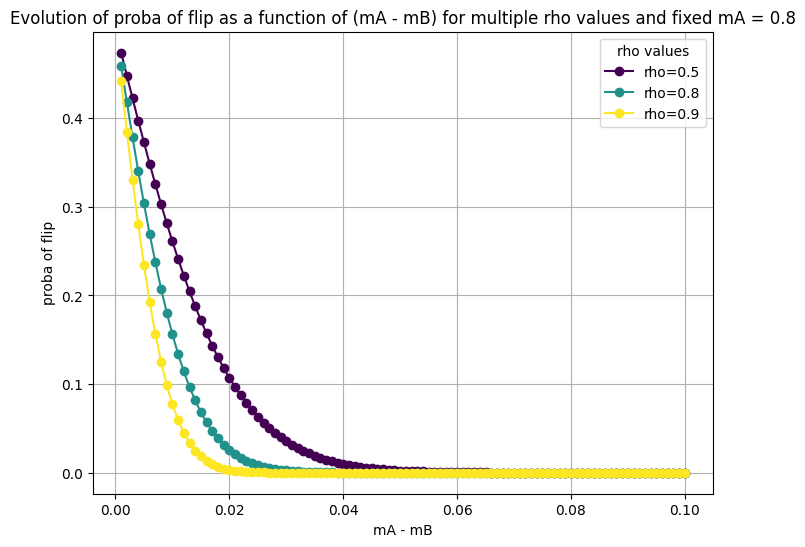

In [ ]:
def varying_rho(n, mA, diff_values, rho_values):
    """
    Plots the evolution of the p-value and test statistic as a function of (pA - pB)
    for multiple pA values for the McNemar test, while keeping p11 fixed.

    Args:
    n : number of samples of the test set
    mA : average value of your dice
    diff_values : list or array of differences between pA and pB (pA - pB)
    rho_values : difefrent values of rho you want to test

    """

    if isinstance(rho_values, (float, int)):
        rho_values = [rho_values]

    colors = plt.cm.viridis(np.linspace(0, 1, len(rho_values)))

    all_proba_flip = {}

    for rho in rho_values:

        proba_flip = []

        for diff in diff_values:

            mB = mA - diff
            try:
                prob = proba_of_flipping_dice(n, mA, mB, rho)
                proba_flip.append(prob)
            except ValueError as e:
                proba_flip.append(None)

        all_proba_flip[rho] = proba_flip

    plt.figure(figsize=(8, 6))
    for i, rho in enumerate(rho_values):
        plt.plot(diff_values, all_proba_flip[rho], marker='o', linestyle='-', color=colors[i], label=f'rho={rho}')

    plt.xlabel('mA - mB')
    plt.ylabel('proba of flip')
    plt.title(f'Evolution of proba of flip as a function of (mA - mB) for multiple rho values and fixed mA = {mA}')
    plt.legend(title='rho values')
    plt.grid(True)
    plt.show()

varying_rho(100, 0.8, np.linspace(0.001,0.1,100), [0.5, 0.8, 0.9])

the flipping is inversely proportional to rho

# Display how the probability of flipping varies as a function of $\rho_{AB}$ (and a given $m_A$ and $m_B$)

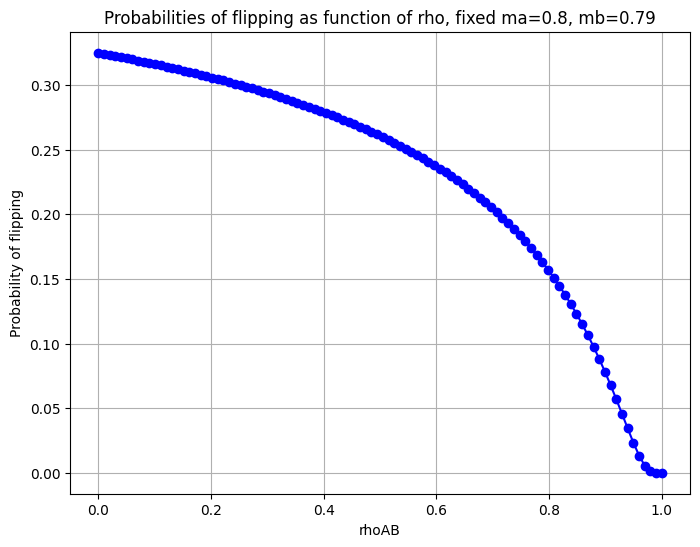

In [ ]:
def varying_rho_proba_flip_mA_mB(n,mA,mB):

   counts = []
   diff=[]

   for rho in np.linspace(0, 1, 100):
     try:
       counts.append(proba_of_flipping_dice(n,mA,mB,rho))
       diff.append(rho)
     except ValueError as e:
       counts.append(None)
       diff.append(None)

   plt.figure(figsize=(8, 6))
   plt.plot(diff, counts, marker='o', linestyle='-', color='b')
   plt.xlabel('rhoAB')
   plt.ylabel('Probability of flipping')
   plt.title(f'Probabilities of flipping as function of rho, fixed ma={mA}, mb={mB}')
   plt.grid(True)
   plt.show()

varying_rho_proba_flip_mA_mB(100,0.8,0.79)

the flipping is indeed inversely proportional to rho

# Display how the probability of flipping varies as a function of n (and for varying $m_A - m_B$)

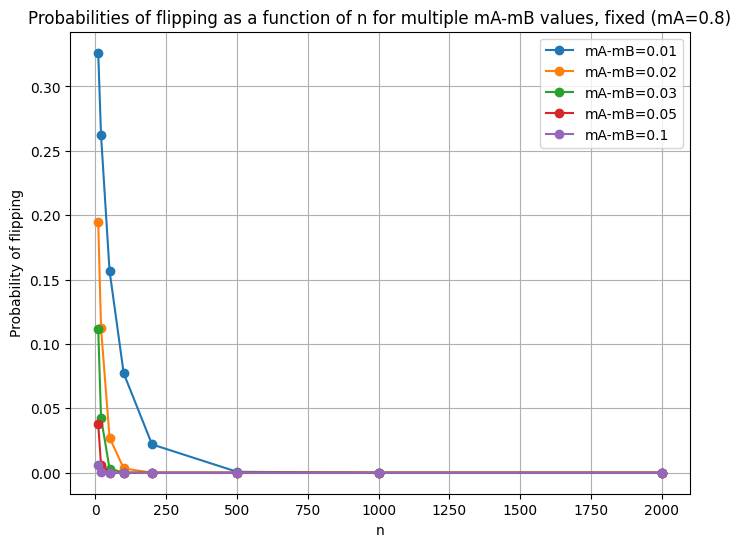

In [ ]:
def varying_n_diff_proba_flip(mA, rhoAB):

   pf = []
   diffs = []

   plt.figure(figsize=(8, 6))

   for diff in [0.01, 0.02, 0.03, 0.05, 0.1]:
     pf=[]
     n_test=[]
     diffs.append(diff)
     for n in [10, 20, 50, 100, 200, 500, 1000, 2000]:
       n_test.append(n)
       mB=mA-diff
       pf.append(proba_of_flipping_dice(n,mA,mB,rhoAB))
     plt.plot(n_test, pf, marker='o', linestyle='-', label=f'mA-mB={diff}')


   plt.xlabel('n')
   plt.ylabel('Probability of flipping')
   plt.title(f'Probabilities of flipping as a function of n for multiple mA-mB values, fixed (mA={mA})')
   plt.legend()
   plt.grid(True)
   plt.show()

varying_n_diff_proba_flip(0.8, 0.9)

# Display how the probability of flipping varies as a function of $\rho_{AB}$ (and for varying $m_A - m_B$)

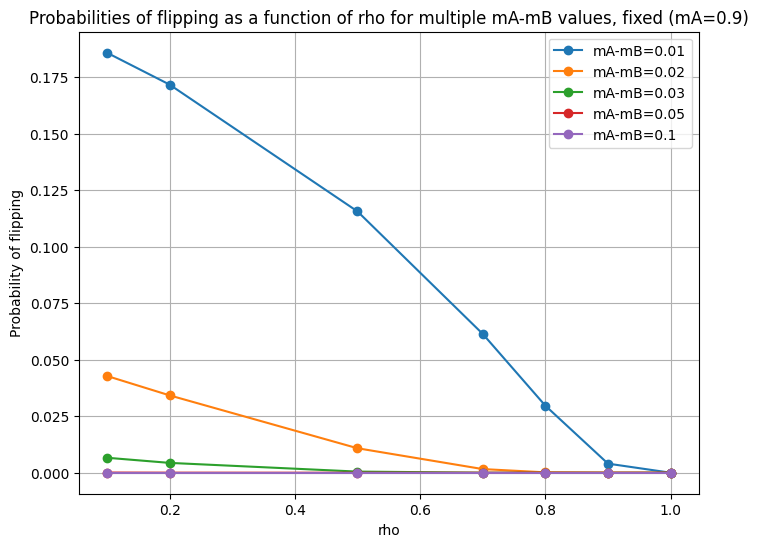

In [ ]:
def varying_rho_diff_proba_flip_2(n,mA):

   counts = []
   diffs = []

   plt.figure(figsize=(8, 6))

   for diff in [0.01, 0.02, 0.03, 0.05, 0.1]:
     pf=[]
     rho_test=[]
     diffs.append(diff)
     for rho in [0.1, 0.2, 0.5, 0.7, 0.8, 0.9, 1]:
       rho_test.append(rho)
       mB=mA-diff
       pf.append(proba_of_flipping_dice(n,mA,mB,rho))
     plt.plot(rho_test, pf, marker='o', linestyle='-', label=f'mA-mB={diff}')


   plt.xlabel('rho')
   plt.ylabel('Probability of flipping')
   plt.title(f'Probabilities of flipping as a function of rho for multiple mA-mB values, fixed (mA={mA})')
   plt.legend()
   plt.grid(True)
   plt.show()

varying_rho_diff_proba_flip_2(100, 0.9)

# We tackle now the problem with a new angle : how does the probability of flipping vary as a function of $(m_A + m_B)/2)$

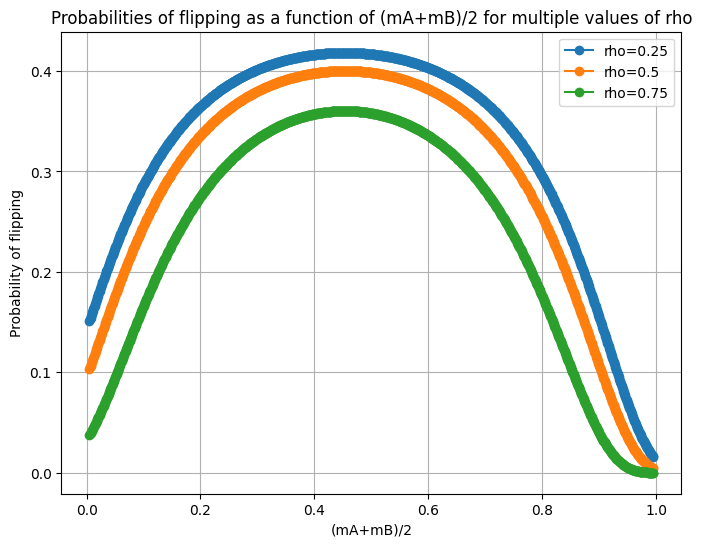

In [ ]:
def plot_flip_average_rho(n, rho_values, mA_range, mB_range):

    all_proba = []
    average = []
    plt.figure(figsize=(8, 6))

    for rho in rho_values:

       avg_values = []
       flip_probabilities = []

       for mA, mB in zip(mA_range, mB_range):
           avg_val = (mA + mB) / 2
           flip_proba = proba_of_flipping_dice(n, mA, mB, rho)
           avg_values.append(avg_val)
           flip_probabilities.append(flip_proba)
       plt.plot(avg_values, flip_probabilities, marker='o', linestyle='-', label=f'rho={rho}')


    plt.xlabel('(mA+mB)/2')
    plt.ylabel('Probability of flipping')
    plt.title(f'Probabilities of flipping as a function of (mA+mB)/2 for multiple values of rho')
    plt.legend()
    plt.grid(True)
    plt.show()

n = 100
rhoAB = 0.5
mA_range = np.linspace(0.01, 1, 1000)
mB_range = np.linspace(0, 0.99, 1000)
rho_range = [0.25,0.5,0.75]

plot_flip_average_rho(n, rho_range, mA_range, mB_range)

for a given difference, the probability of flip is normally distributed around mA + mB / 2

and as always, the probability of flip is inversely proportional to rho

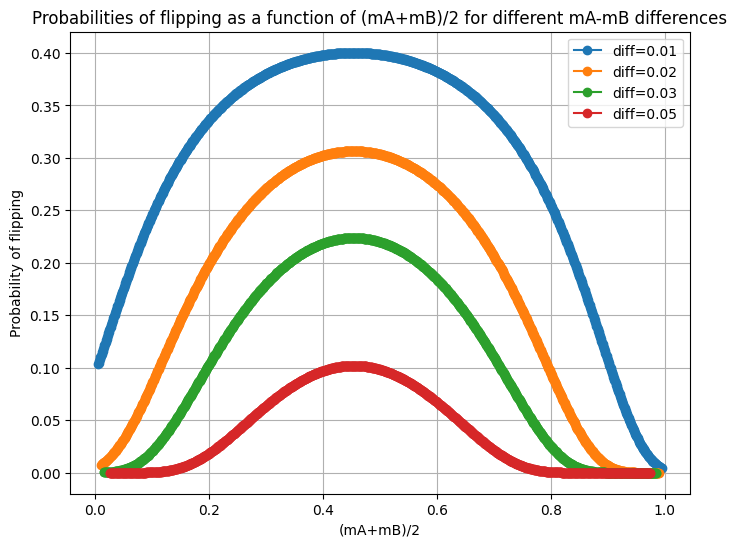

In [ ]:
def plot_flip_average_diff(n, rho, diff_values, mA_start, mA_end, num_points=1000):

    plt.figure(figsize=(8, 6))

    for diff in diff_values:
        mA_range = np.linspace(mA_start + diff, mA_end, num_points)
        mB_range = np.linspace(mA_start, mA_end - diff, num_points)

        avg_values = []
        flip_probabilities = []

        for mA, mB in zip(mA_range, mB_range):
            avg_val = (mA + mB) / 2
            flip_proba = proba_of_flipping_dice(n, mA, mB, rho)
            avg_values.append(avg_val)
            flip_probabilities.append(flip_proba)

        plt.plot(avg_values, flip_probabilities, marker='o', linestyle='-', label=f'diff={diff}')

    plt.xlabel('(mA+mB)/2')
    plt.ylabel('Probability of flipping')
    plt.title(f'Probabilities of flipping as a function of (mA+mB)/2 for different mA-mB differences')
    plt.legend()
    plt.grid(True)
    plt.show()


n = 100
rho = 0.5
diff_values = [0.01, 0.02, 0.03, 0.05]  # Différences entre mA et mB
mA_start = 0
mA_end = 1

plot_flip_average_diff(n, rho, diff_values, mA_start, mA_end)

<ipython-input-13-6ead61e1292d>:26: RuntimeWarning: divide by zero encountered in scalar divide
  normalized_width_student = (conf_interval.right - conf_interval.left)/empirical_mean


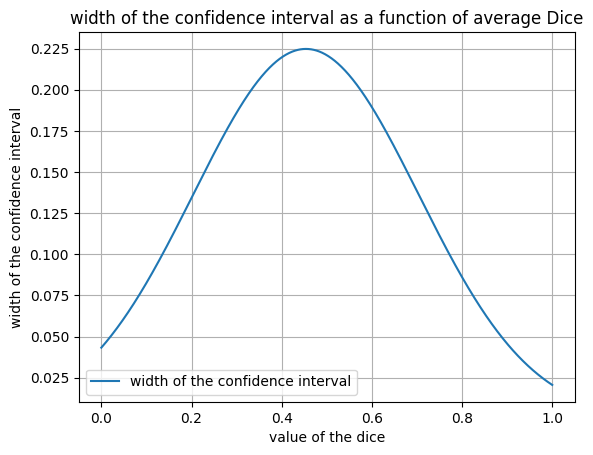

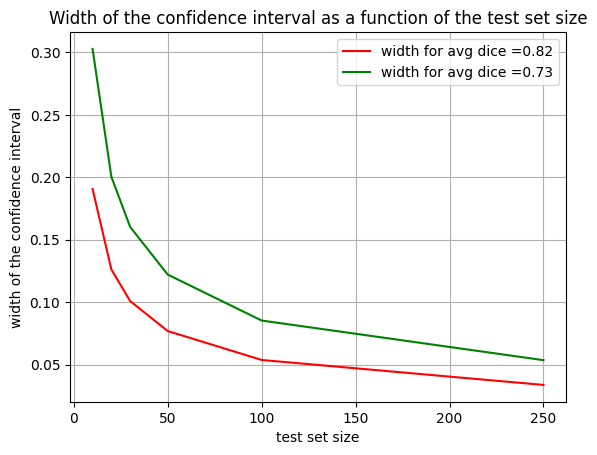

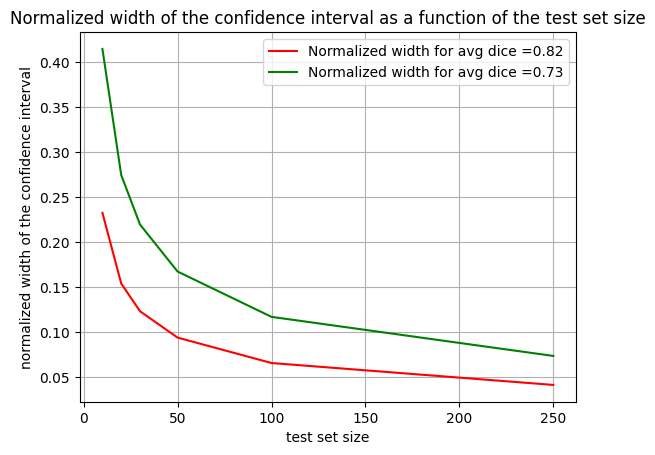

In [ ]:
import scipy.stats as stats
import pandas as pd

dice_ex = np.linspace(0,1,1000)

def sd_imputation(dice):
  dice_100 = 100*dice
  log_sd = 2.0310 + 0.0726*dice_100 - 0.0008*(dice_100)**2
  return np.exp(log_sd)/100

def confidence_intervals_test(empirical_mean, n):

    alpha = 0.05 # Confidence level

    sd = sd_imputation(empirical_mean)
    std_error_param = sd/np.sqrt(n)

    t_student = stats.t.ppf(1 - alpha / 2, n)

    lower = empirical_mean - t_student * std_error_param # Parametric method with normal
    upper = empirical_mean + t_student * std_error_param

    conf_interval = pd.Interval(left=lower, right=upper, closed='both')

    narrowness_student = (conf_interval.right - conf_interval.left)
    normalized_width_student = (conf_interval.right - conf_interval.left)/empirical_mean

    return narrowness_student, normalized_width_student


def varying_narrow(n):

  dice_ex = np.linspace(0,1,1000)
  narrownesses = []
  normalized_widths = []

  for dice in dice_ex:

    narrowness_student, normalized_width_student = confidence_intervals_test(dice,n)

    narrownesses.append(narrowness_student)
    normalized_widths.append(normalized_width_student)

  plt.figure()
  plt.title("width of the confidence interval as a function of average Dice")
  plt.plot(dice_ex, narrownesses, label = "width of the confidence interval")
  plt.xlabel('value of the dice')
  plt.ylabel('width of the confidence interval')
  plt.legend()
  plt.grid()
  plt.show()

varying_narrow(50)

def varying_n(dice1, dice2):

  n_list = [10,20,30,50,100,250]
  narrownesses = []
  normalized_widths = []
  narrownesses2 = []
  normalized_widths2 = []

  for n in n_list:

    narrowness_student, normalized_width_student = confidence_intervals_test(dice1,n)
    narrowness_student2, normalized_width_student2 = confidence_intervals_test(dice2,n)

    narrownesses.append(narrowness_student)
    normalized_widths.append(normalized_width_student)
    narrownesses2.append(narrowness_student2)
    normalized_widths2.append(normalized_width_student2)

  plt.figure()
  plt.title("Width of the confidence interval as a function of the test set size")
  plt.plot(n_list, narrownesses, color = 'r', label = f"width for avg dice ={dice1}")
  plt.plot(n_list, narrownesses2, color = 'g', label = f"width for avg dice ={dice2}")
  plt.xlabel("test set size")
  plt.ylabel("width of the confidence interval")
  plt.legend()
  plt.grid()
  plt.show()

  plt.figure()
  plt.title("Normalized width of the confidence interval as a function of the test set size")
  plt.plot(n_list, normalized_widths, color = 'r', label = f"Normalized width for avg dice ={dice1}")
  plt.plot(n_list, normalized_widths2, color = 'g', label = f"Normalized width for avg dice ={dice2}")
  plt.xlabel("test set size")
  plt.ylabel("normalized width of the confidence interval")
  plt.legend()
  plt.grid()
  plt.show()

varying_n(0.82,0.73)
